In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

base_url = "https://books.toscrape.com/catalogue/"
books = []

for page_num in range(1, 51):
    url = f"https://books.toscrape.com/catalogue/page-{page_num}.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = soup.find_all('article', class_='product_pod')

    for article in articles:
        title = article.h3.a['title']
        
        price = article.find('p', class_='price_color').get_text()
        price = float(price[1:])  
        
        star_rating = article.find('p', class_='star-rating')['class'][1]
        star_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
        star_value = star_map.get(star_rating, 0)
        
        book_url = base_url + article.h3.a['href'].replace('../../../', '')

        book_response = requests.get(book_url)
        book_soup = BeautifulSoup(book_response.content, 'html.parser')

        description = book_soup.find('meta', {'name': 'description'})
        description = description['content'].strip() if description else 'No description available'

        category = book_soup.find('ul', class_='breadcrumb').find_all('a')[2].get_text()

        books.append([title, category, price, star_value, description])
    
    time.sleep(1)

df = pd.DataFrame(books, columns=['Title', 'Category', 'Price', 'Star Rating', 'Description'])

df.to_csv('books_data.csv', index=False)
print("Data scraping completed and saved as 'books_data.csv'.")


Data scraping completed and saved as 'books_data.csv'.


In [2]:
df = pd.read_csv('books_data.csv')

category_counts = df['Category'].value_counts()
print("Number of books per category:")
print(category_counts)

avg_price_per_category = df.groupby('Category')['Price'].mean().sort_values(ascending=False)
print("\nAverage price per category:")
print(avg_price_per_category)

avg_star_per_category = df.groupby('Category')['Star Rating'].mean().sort_values(ascending=False)
print("\nAverage star rating per category:")
print(avg_star_per_category)


Number of books per category:
Default               152
Nonfiction            110
Sequential Art         75
Add a comment          67
Fiction                65
Young Adult            54
Fantasy                48
Romance                35
Mystery                32
Food and Drink         30
Childrens              29
Historical Fiction     26
Poetry                 19
Classics               19
History                18
Horror                 17
Womens Fiction         17
Science Fiction        16
Science                14
Music                  13
Business               12
Thriller               11
Travel                 11
Philosophy             11
Humor                  10
Autobiography           9
Art                     8
Psychology              7
Religion                7
Spirituality            6
Christian Fiction       6
New Adult               6
Sports and Games        5
Biography               5
Self Help               5
Health                  4
Christian               3
Politics

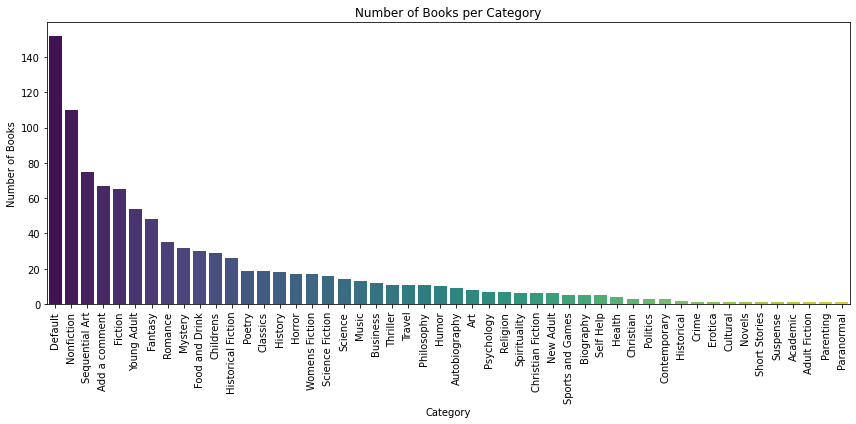

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('books_data.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Books per Category')
plt.xlabel('Category')
plt.ylabel('Number of Books')
plt.tight_layout()
plt.show()


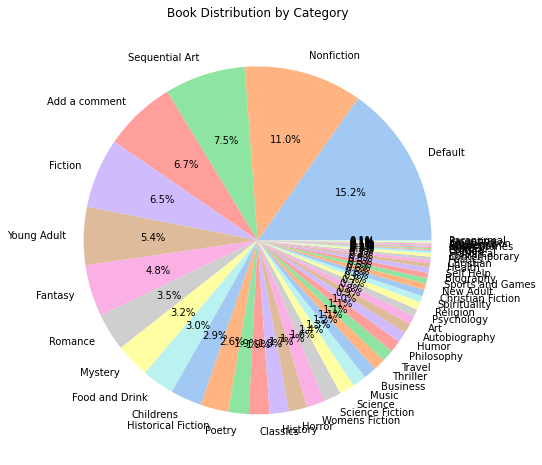

In [5]:
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Book Distribution by Category')
plt.show()


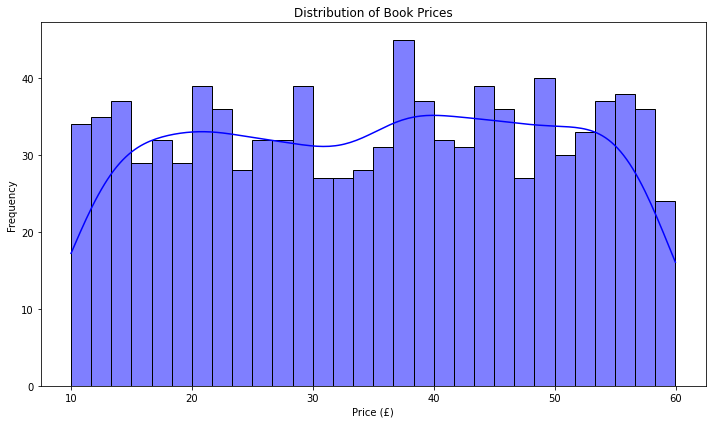

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Book Prices')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


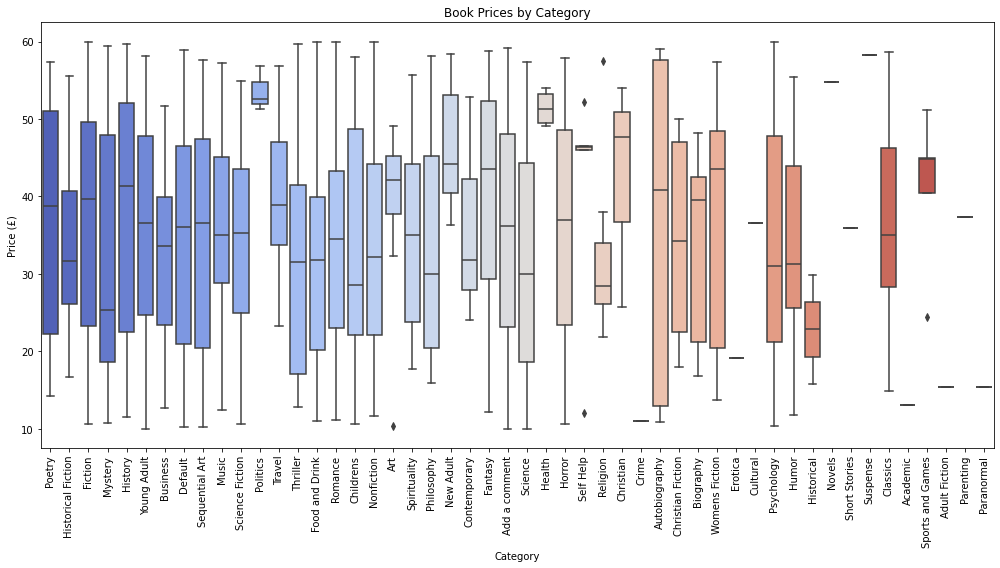

In [7]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Category', y='Price', data=df, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Book Prices by Category')
plt.xlabel('Category')
plt.ylabel('Price (£)')
plt.tight_layout()
plt.show()


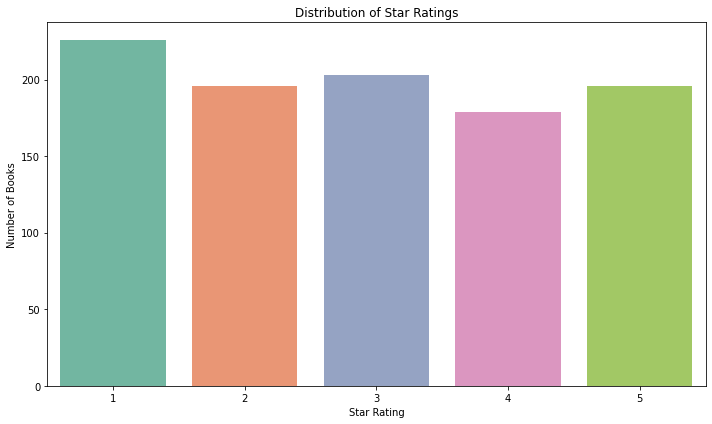

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Star Rating', data=df, palette='Set2')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Books')
plt.tight_layout()
plt.show()



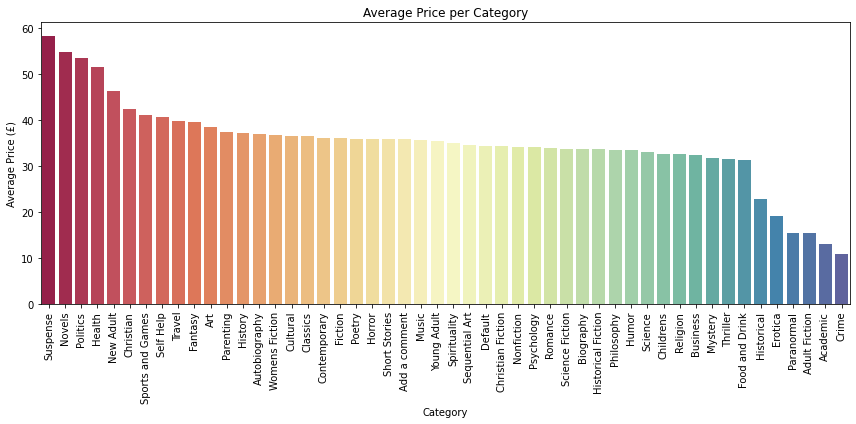

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_per_category.index, y=avg_price_per_category.values, palette='Spectral')
plt.xticks(rotation=90)
plt.title('Average Price per Category')
plt.xlabel('Category')
plt.ylabel('Average Price (£)')
plt.tight_layout()
plt.show()


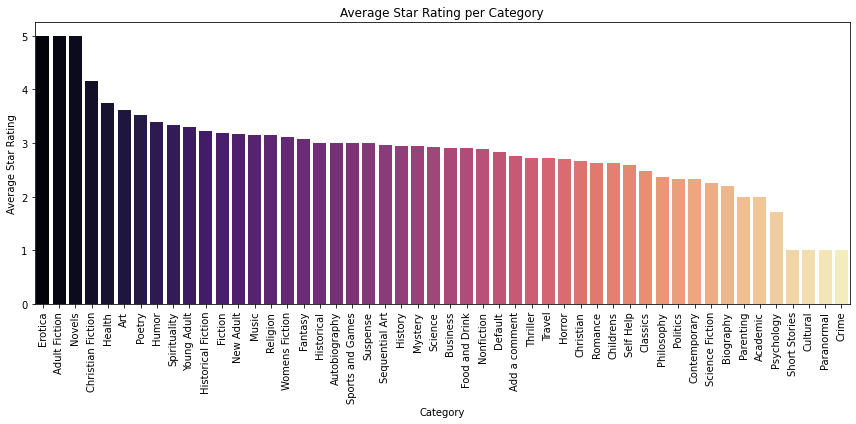

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_star_per_category.index, y=avg_star_per_category.values, palette='magma')
plt.xticks(rotation=90)
plt.title('Average Star Rating per Category')
plt.xlabel('Category')
plt.ylabel('Average Star Rating')
plt.tight_layout()
plt.show()

In [11]:
import openai

df = pd.read_csv('books_data.csv')

def recommend_books(category, min_star=3):
    recommended_books = df[(df['Category'].str.contains(category, case=False)) & (df['Star Rating'] >= min_star)]
    return recommended_books[['Title', 'Category', 'Price', 'Star Rating', 'Description']]

category_input = "Fiction"
min_star_input = 4

recommended = recommend_books(category_input, min_star_input)

print(f"Books recommended from category '{category_input}' with at least {min_star_input} stars:")
print(recommended)


Books recommended from category 'Fiction' with at least 4 stars:
                                                 Title            Category  \
28   Worlds Elsewhere: Journeys Around Shakespeare’...          Nonfiction   
42                         Private Paris (Private #10)             Fiction   
43   #HigherSelfie: Wake Up Your Life. Free Your So...          Nonfiction   
46                        We Love You, Charlie Freeman             Fiction   
48   Unseen City: The Majesty of Pigeons, the Discr...          Nonfiction   
..                                                 ...                 ...   
969                              Lost Among the Living  Historical Fiction   
972                      Kitchens of the Great Midwest             Fiction   
977  Having the Barbarian's Baby (Ice Planet Barbar...     Science Fiction   
989                                       Bright Lines             Fiction   
997  A Spy's Devotion (The Regency Spies of London #1)  Historical Fiction   

In [49]:
import openai
import pandas as pd

df = pd.read_csv('books_data.csv')

user_prompt = "filter the books in Science category, and then filter the obtained books with more than 3 stars"

def generate_book_data_prompt(books):
    prompt = "recommend me some books in the only in the Science Category.\n"
    for index, row in books.iterrows():
        description = str(row['Description']) if pd.notna(row['Description']) else "No description available"
        
        prompt += (f"- Title: {row['Title']}, Category: {row['Category']}, "
                   f"Price: £{row['Price']}, Rating: {row['Star Rating']} stars.\n"
                   f"Description: {description[:150]}...\n")  # Shortened description if too long
    prompt += "\nBased on this list, please recommend books that strictly meet the criteria."
    return prompt

        
book_data_prompt = generate_book_data_prompt(df)

final_prompt = book_data_prompt + user_prompt

openai.api_key = 'your api key'

response = openai.ChatCompletion.create(
    model="gpt-4o-mini",  
    messages=[
        {"role": "system", "content": "You are a helpful assistant that recommends books based on the user's preferences."},
        {"role": "user", "content": final_prompt}
    ],
    temperature=0  
)

print("\nAI-based book recommendations:")
print(response['choices'][0]['message']['content'].strip())



AI-based book recommendations:
Based on your criteria, here are the books in the Science category that have a rating of more than 3 stars:

1. **Title:** The Disappearing Spoon: And Other True Tales of Madness, Love, and the History of the World from the Periodic Table of the Elements  
   **Price:** £57.35  
   **Rating:** 5 stars  
   **Description:** From New York Times bestselling author Sam Kean comes incredible stories of science, history, finance, mythology, the arts, medicine, and more, as told through the lens of the periodic table.

2. **Title:** The Grand Design  
   **Price:** £13.76  
   **Rating:** 3 stars  
   **Description:** THE FIRST MAJOR WORK IN NEARLY A DECADE BY ONE OF THE WORLD’S GREAT THINKERS—A MARVELOUSLY CONCISE BOOK WITH NEW ANSWERS TO THE ULTIMATE QUESTIONS OF LIFE.

3. **Title:** Seven Brief Lessons on Physics  
   **Price:** £30.6  
   **Rating:** 4 stars  
   **Description:** Everything you need to know about the beauty of modern physics in less than 10